In [1]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML

***
    
    Ligação à base de dados

***

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [3]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Nome das colunas

In [4]:
def col_names(table):
    '''
    Função que retorna os nomes das colunas de uma tabela
    
    Parâmetros : 
        - table : tabela de interesse

    return : 
        - pandas DataFrame : nomes das colunas
    '''

    cur = conn.cursor()
    cur.execute('''
                SELECT column_name
                FROM information_schema.columns
                WHERE table_name = %s;''', (table,))

    cnames = pd.DataFrame(cur.fetchall())
    #cnames = [row[0] for row in cur.fetchall()]
    return cnames

HTML(pd.DataFrame(col_names('contratos')).to_html(index=True))

,0
0,id
1,n_anuncio
2,anuncio_preco_base
3,anuncio_proposalDeadline
4,anuncio_cnccs
5,anuncio_contractingProcedureAliasID
6,anuncio_contractingProcedureId
7,anuncio_drPublicationDate
8,anuncio_dreNumber
9,anuncio_dreSeries


    Número de Contratos


In [5]:
def n_contracts(table):
    '''
    Retorna o número de contratos de uma tabela pertencente à base de dados

    Parâmetros : 
        - table : tabela de interesse

    return : 
        - int : número de contrato
    '''
    
    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "{}"; '''.format(table))
    ncontract = cur.fetchone()[0]
    return ncontract

n_contracts("contratos")

20577

    Organizar Contratos por Tipo de Procedimento

In [6]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,9473
Consulta Prévia,4217
Concurso público,3723
Ao abrigo de acordo-quadro (art.º 259.º),2351
Ao abrigo de acordo-quadro (art.º 258.º),503
Ajuste direto simplificado,95
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",87
Consulta Prévia Simplificada,57
Concurso limitado por prévia qualificação,54
Procedimento de negociação,6


In [7]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,4744
Aquisição de bens móveis,4152
Empreitadas de obras públicas,403
Locação de bens móveis,73
Aquisição de serviços<br/>Aquisição de bens móveis,42
Aquisição de bens móveis<br/>Aquisição de serviços,32
Locação de bens móveis<br/>Aquisição de serviços,4
Concessão de obras públicas,4
Aquisição de serviços<br/>Locação de bens móveis,3
Aquisição de serviços<br/>Empreitadas de obras públicas,3


In [8]:
def h(df):
    return HTML(df.to_html(index=False))

***

# Funções


***

    ID's dos contratos

In [9]:
def all_ids(table):
    '''
    Função que retorna todos os ids dos contratos de uma tabela

    Parâmetros :    
        - table : tabela de interesse

    Return : 
        - list : ids de todos os contratos de uma tabela 
    '''

    cur = conn.cursor()
    cur.execute(''' 
                SELECT id
                FROM "{}"; '''.format(table)) 
    return list(cur.fetchall())


ids = all_ids("contratos")

    ID's dos diferentes tipos de procedimentos

    1. Ajuste Direto Regime Geral

In [10]:
def ajuste_dir():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Ajuste Direto Regime Geral';''')
    
    return list(cur.fetchall())

    2. Consulta Prévia

In [11]:
def consulta_prev():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Consulta Prévia';''')
    
    return list(cur.fetchall())

    3. Concurso Público

In [12]:
def concurso_pub():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Concurso público';''')
    
    return list(cur.fetchall())

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [13]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

680

In [14]:
def cpv_direto(cpv):
    
    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Ajustes Diretos em Regime Geral

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Ajuste Direto Regime Geral';''', (cpv + '%',))
    
    return cur.fetchall()

In [15]:
def cpv_cpub(cpv):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Concurso público';''', (cpv + '%',))

    
    return cur.fetchall()

In [16]:
def cpv(cpv, proc):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = %s;''', (cpv + '%', proc))

    
    return cur.fetchall()

In [17]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

    Função que retorna contrato para número de id

In [18]:
def contrato(ide):
    '''
    Função que retorna linha da database referente ao contrato com id = ide
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return pd.DataFrame(cur.fetchall())


def contratos(ide):
    '''
    Função que retorna contratos referentes a um conjunto de ids

    Parâmetros :
        ide : tuplo de id's de anúncios

    return:
        dataframe com contratos
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(ide),))
    return pd.DataFrame(cur.fetchall())

    Função que retorna contratos a partir do número do anúncio

In [19]:
cur = conn.cursor()
cur.execute('''
            SELECT * 
            FROM "contratos"
            WHERE "n_anuncio" = '8223/2023';''')

(cur.fetchall())

[('10332117',
  '8223/2023',
  '3139486.56',
  '30',
  'False',
  '6506218',
  '13041258',
  '2023-05-22',
  '98',
  '2',
  'False',
  'False',
  'https://dre.pt/application/file/213330772',
  'Anúncio de procedimento',
  'Concurso público',
  'Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação',
  '2023-11-08',
  '2023-11-03',
  '557776.80',
  '420',
  'SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)',
  'Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos',
  'Sys-Match - Consultores de Sistemas de Informação, Lda (504665901)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=323846)',
  'IDW - Consultoria em Serviços de Informação, Lda (504243926)|||INDRA III  SOLUÇÕES  TECNOLOGIA (TECNOCOMPORT) (503222364)|||Capgemini Portugal, S.A. (504272179)|||Accenture - Consultores de Gestão

In [20]:
contrato('10230172')

""


    Preço contratual

In [21]:
def preco_contrato1(ide):
    '''
    Função que retorna preço contratual a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return float(cur.fetchone()[0])



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_contrato2(ide, table = ""):
    '''
    Função que retorna preço contratual a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))
    return float((cur.fetchone())[0])


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


#def preco_contrato3(id_anuncio):
#    
#    '''
#    Função que retorna preço contratual a partir de uma lista de ids de anúncios
#    '''
#    
#    cur.execute('''
#        SELECT preco_contratual
#        FROM "contratos"
#        WHERE id IN %s; ''', (tuple(id_anuncio),))
#    
#    return np.array(cur.fetchall()[0])

def preco_contrato3(id_anuncio):
    
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

   #preco = list(cur.fetchall())
   #
   #n = len(preco)
   #p = np.zeros(n)

   #for i in range(n):
   #    p[i] = (preco[i][0]).replace(".", "").replace(",",".").replace("€","")

    p = np.array(cur.fetchall(), dtype = float).reshape(len(id_anuncio),)
    return p


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    



def preco_contrato4(ide, table = ""):
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios para uma determinada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    
    if table == "": 
        table = "contratos"

    
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id IN %s; '''.format(table), (tuple(ide),))
    
    return np.asarray(cur.fetchall())
    

    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------

    Preço Base

In [22]:
def preco_base(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - tuplo : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    
    return cur.fetchone()



def preco_base1(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))


    preco = cur.fetchone()[0]
    p1 = float(preco[:-2].replace(".", "").replace(",","."))
    
    return p1



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_base2(ide, table = ""):
    '''
    Função que retorna preço base a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"


    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))


    preco = cur.fetchone()[0]

    if preco != 0:
        p1 = float(preco[:-2].replace(".", "").replace(",","."))
    else:
        p1 = 0
    
    return p1
    


# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


def preco_base3(id_anuncio):
    
    '''
    Função que retorna preço base a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

    preco = list(cur.fetchall())


    # Como os valores do preco base estão no formato ---.---,--€ é precio converter em -------.-- para comparar posteriormente
    n = len(preco)
    p = np.zeros(n)
    
    for i in range(n):

        if preco[i][0] != 'None':
            p[i] = (preco[i][0]).replace(".00", "").replace(".", "").replace(",",".").replace("€","")

        else:
            pass
            
    return p
    

In [23]:
## Conjunto de todos os preços base
#a = preco_base3(ids)
#
##pd.DataFrame(a).describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
#print("Nr de Zero Values :", len(a) - (np.count_nonzero(a)))
#print("Nr de Non Zero Values :", (np.count_nonzero(a)))
#print("% non zero values : ",round(np.count_nonzero(a)/len(a) * 100,1))

#nn_index = np.where(a != 0)[0]                 # índices dos ids dos contratos com preço base não nulo
#
#id1 = np.array(ids)                            # Transformação da lista de ids em array. Assim podemos extrair os ids não nulos usando os índices acima
#
#id2 = id1[nn_index]
#id2 = id2.reshape(len(id2),1)
#
#ids_nn = tuple(map(tuple, id2))                # ids não nulos. É preciso converter em tuplo para usar como input na função de preço base
#
#pb = preco_base3(ids_nn)
#pc = preco_contrato3(ids_nn)

***

    Lista de de Contratos Públicos
    
***

In [24]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323405,15555/2023,137670.00,6,False,6699898,13437191,2023-09-19,182,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382733
1,10322139,13241/2023,592500.00,36,False,6640568,13311154,2023-08-04,151,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384415
2,10324626,15934/2023,150151.14,3,False,6708714,13455812,2023-09-25,186,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699386436
3,10270922,7447/2023,92900.00,21,False,6491309,12998447,2023-05-10,90,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468545
4,10325177,1698/2023,1749480.72,36,False,6512074,13055482,2023-07-28,146,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699385716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,10338639,7202/2023,144452.00,30,False,6475542,12974977,2023-05-05,87,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699934587
97,10337509,1517/2023,191970.00,6,False,6551723,13123526,2023-07-10,132,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699943114
98,10337405,8663/2023,197120.00,30,False,6516042,13064938,2023-05-26,102,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699943238
99,10337328,6875/2023,132594.00,30,False,6468185,12957926,2023-05-02,84,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699943323


***

    Lista de Ajustes Diretos 

***

In [25]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10270927,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468541
2,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
3,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
4,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,10337194,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699943455
388,10336780,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699943951
389,10336738,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699943989
390,10336717,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,ORDEM DOS ADVOGADOS - UNIDADE ORGÂNICA: CONSEL...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699944020


***

# Flags

***

In [26]:
def redflag(pbase, pcontr, tol, ids, r):
    
    """
    Função que calcula a diferença entre o preço base e preço contratual de um contrato realizado
    Se o preço contratual estiver contido num intervalo em torno do preço base é levantada um flag
    O intervalo é definido pelo parâmetro tolerância e é definido como : [preço_base - preço_base*tolerância, preço_base + preço_base*tolerância]
    Se o preço base não estiver definido, é levantada uma flag também 

    Parâmetros de entrada : 
        pbase : array com os preços base
        pcontr : array com os preços contratuas
        tol : valor da tolerância. Só pode tomar valores entre 0 e 1
        ids : id's dos contratos em questão
        r : ratio máximo permitido entre preço base / preço contratual

    Return : 
        f : tuplo com os id's dos contratos com flag associada
    """

    # Garantir que dimensão dos arrays com os preços é igual
    if len(pbase) != len(pcontr):
        return "Error : dim pbase != dim pcontr"

    # Garantir que tolerância é um numero entre 0 e 1
    if tol < 0 or tol > 1 :
        return "Error : tolerance must belong between 0 and 1"

    # Número de preços base
    n = len(pbase)

    # Array que guarda ocorrência - ou não - de uma flag
    flags = np.zeros(n)

    for i in range(n):

        # Definir limites superior e inferior, respetivamente
        up_lim = pbase[i] * (1 + tol)
        lo_lim = pbase[i] * (1 - tol)
        ratio = pbase[i] / pcontr[i]
        
        if lo_lim < pcontr[i] < up_lim :
            flags[i] = 1
            
        if pbase[i] == 0 :
            flags[i] = 1    

        if  ratio > r :
            flags[i] = 1
            
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))
    
    return f

In [49]:
def redflag2(t,ids):
    
    """
    Função que verifica, dentro dos ajustes diretos, se o preço contratual é superior a 20.000€
    Só funciona para Aquisição de Serviços

    Parâmetros : 
        t : dataframe com todos os ajustes diretos. Esta dataframe é o  output da função 'contratos'
        ids : id's dos contratos que dizem respeito aos ajustes diretos. Estes id's são dados pelo output da função CPV

    Return :
        tuplo : f é o conjunto de contratos onde é disparada uma flag
    """

    n = len(t)

    c = t.TipoProcedimento.unique()
    #print(c)
    
    flags = np.zeros(n)
    
    #for i in range(n):
    #    if t.TipoProcedimento[i] == 'Aquisição de serviços':
    #        if t.PrecoContratual[i] > 20000:
    #            flags[i] = 1

    prices = t.PrecoContratual
    flags[np.where(prices > 20000)] = 1

    fundamento = t.iloc[:,21]
    flags[np.where(fundamento == "")] = 1
    
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))

    return f

***

# Concurso Público

***

In [30]:
# Preço Base e Preço Contratual de todos os contratos públicos realizados para CPV's começados por 72
pb = preco_base3(cpub)
pc = preco_contrato3(cpub)

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

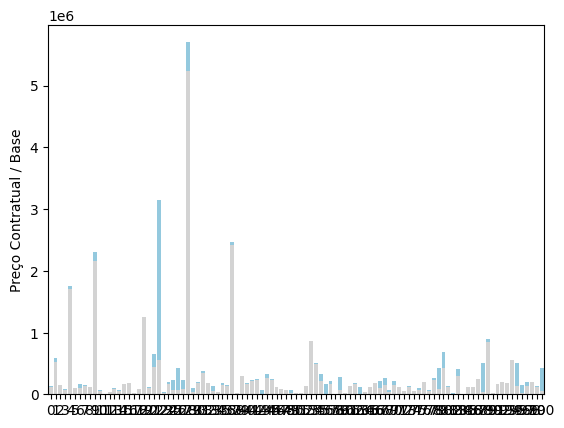

In [31]:
df = contratos(cpub).iloc[:,[2,18]]
df = df.rename(columns={2: 'PrecoBase', 18:'PrecoContratual'})
df = df.astype('float')

sns.barplot(x = df.index, y = df.PrecoBase, color = 'skyblue')
sns.barplot(x = df.index, y = df.PrecoContratual, color = 'lightgray', fill=0.1)
plt.ylabel('Preço Contratual / Base')
plt.show()

- preco final e preco base : fazer o sumario deste array de valores, ver outliers e tal

- distribuição dos dois preços e da diferença

- arranjar plot : organizar dados por mes/ano dependendo do span

- testes de hipóteses para distribuições

- categorizar range dos precos em 3 intervalos p. ex.

In [32]:
#print(np.where(pb/pc > 400))

HTML(contrato(cpub[22]).to_html(index=False))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10332117,8223/2023,3139486.56,30,False,6506218,13041258,2023-05-22,98,2,False,False,https://dre.pt/application/file/213330772,Anúncio de procedimento,Concurso público,Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação,2023-11-08,2023-11-03,557776.80,420,"SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)","Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos","Sys-Match - Consultores de Sistemas de Informação, Lda (504665901)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=323846)","IDW - Consultoria em Serviços de Informação, Lda (504243926)|||INDRA III SOLUÇÕES TECNOLOGIA (TECNOCOMPORT) (503222364)|||Capgemini Portugal, S.A. (504272179)|||Accenture - Consultores de Gestão, S.A. (502309440)|||NOS - Comunicações S.A. (502604751)|||MARCOS BARROSA, UNIPESSOAL LDA (515371378)|||WINNING, LDA. (510098711)|||HLTSYS - HEALTHSYSTEMS, LDA (510552544)|||IGNIT PEOPLE , S.A. (515777048)|||AXIANSEU II DIGITAL CONSULTING, S.A. (501774360)",https://www.base.gov.pt/Base4/pt/detalhe/?type=anuncios&id=347532,https://community.vortal.biz/PRODPublic/Tendering/OpportunityDetail/Index?noticeUID=PT1.NTC.2397171,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2072887&ext=.pdf,false,72500000-0,False,None,None,True,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com a informática,Principal,557776.8,Serviços de consultoria para serviços de integração (PRR) - Lote 2 - Serviços de produção de especificações técnicas e de domínio da informação,Não aplicável,None,"Portugal, Lisboa<BR/>Portugal, Porto",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",Plano de Recuperação e Resiliência (PRR) – artigo 6º da Lei n.º30/2021,None,1699503091


In [33]:
redflag(pb, pc, 0.1, cpub, 20)

/tmp/ipykernel_89512/4280521597.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = pbase[i] / pcontr[i]


(('10324626',),
 ('10325177',),
 ('10270503',),
 ('10326579',),
 ('10270055',),
 ('10271560',),
 ('10271100',),
 ('10273652',),
 ('10273546',),
 ('10273533',),
 ('10273490',),
 ('10285558',),
 ('10332117',),
 ('10281794',),
 ('10281471',),
 ('10280375',),
 ('10280297',),
 ('10284270',),
 ('10286838',),
 ('10285595',),
 ('10288280',),
 ('10291509',),
 ('10290955',),
 ('10293359',),
 ('10292066',),
 ('10296443',),
 ('10295857',),
 ('10295337',),
 ('10295167',),
 ('10299255',),
 ('10297408',),
 ('10297391',),
 ('10300291',),
 ('10307301',),
 ('10306289',),
 ('10308597',),
 ('10307803',),
 ('10312461',),
 ('10333899',),
 ('10333427',),
 ('10333165',),
 ('10336036',),
 ('10335594',),
 ('10335504',),
 ('10311506',),
 ('10310617',),
 ('10314211',),
 ('10314006',),
 ('10313923',),
 ('10312816',),
 ('10316944',),
 ('10315878',),
 ('10318582',),
 ('10321490',),
 ('10320992',),
 ('10337405',),
 ('10337328',),
 ('10337213',))

***

# Ajuste Direto Regime Geral

***

In [50]:
ajustesdir = contratos(ajdir)
ajustesdir = ajustesdir.rename(columns={18:'PrecoContratual', 38:'TipoProcedimento'})

ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count        392.00
mean       42260.99
std       189885.76
min          300.00
25%         7785.69
50%        14335.31
75%        19974.00
max      3415500.00
Name: PrecoContratual, dtype: object

In [51]:
# Conjunto de fundamentações para ajustes diretos
(ajustesdir).groupby(21).size()

21
Artigo 20.º, alínea a) do Decreto Legislativo Regional n.º 27/2015/A, de 29.12                                       5
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos                                                     216
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos e artigo 4.º, nº 1 do DLR nº 34/2008/M, de 14.08     15
Artigo 21.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       1
Artigo 22.º, n.º 1, alínea b) do Código dos Contratos Públicos                                                       1
Artigo 24.º, n.º 1, alínea a) do Código dos Contratos Públicos                                                       2
Artigo 24.º, n.º 1, alínea b) do Código dos Contratos Públicos                                                       1
Artigo 24.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                      12
Artigo 24.º, n.º 1, alínea d) do Código dos C

In [52]:
#HTML(ajustesdir.to_html(index = False))

In [53]:
# Valor máximo de um ajuste direto é mais de 3.000.000,00€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 3000000)[0])

# ID do contrato correspondente
# ajdir[30]

HTML((contrato(ajdir[30])).to_html(index=True))

[30]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,10323555,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,2023-11-02,2023-11-02,3415500.00,1096,"Instituto de Informática, I. P. (504322915)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1957)","Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos","UNISYS, S.L.U. (B-82538273)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1152098)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071204&ext=.pdf,false,72200000-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de consultoria e de programação de software,Principal,3415500.0,2323000197 - Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,Não aplicável,None,"Portugal, Lisboa, Oeiras",Não aplicável.,Não aplicável.,None,False,False,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382506


In [54]:
# Ajustes Diretos com preço contratual superior a 20.000€
h(contratos(redflag2(ajustesdir, ajdir)))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10326169,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",2023-11-03,2023-11-02,35000.00,427,"Agência Para A Modernização Administrativa, Ip (508184509)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=99)","Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos","Unipartner IT Services, S.A. (513662332)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1031653)",None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/Njg1Mzg1,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071630&ext=.pdf,false,72200000-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços<br/>Aquisição de bens móveis,Serviços de consultoria e de programação de software,Principal,35000.0,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",ausência de recursos próprios,None,"Portugal, Lisboa, Lisboa",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
10324999,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Aquisição de serviços para a Renovação da subscrição de Feeds – Open Source Intel - Artic Security,2023-11-03,2023-06-26,34000.00,1096,Gabinete Nacional de Segurança (GNS) (600056120)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=68917),"Artigo 24.º, n.º 1, alínea e), subalínea i) do Código dos Contratos Públicos",Arctic Security (FI28462522)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4861458),None,None,None,None,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,34000.0,Renovação da subscrição de Feeds – Open Source Intel - Artic Security,Não aplicável,None,"Portugal, Lisboa, Lisboa",Não aplicável.,Não aplicável.,None,False,False,None,None,True,"Artigo 95.º, n.º 2, a), a segurança pública interna ou externa justifica-o",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385859
10326178,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"Aquisição de serviços de consultoria de SEO, nos termos melhor descritos no Caderno de Encargos.\n",2023-11-03,2021-06-25,24775.00,366,Associação de Promoção da Região Autónoma da Madeira (511236077)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=481685),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos e artigo 4.º, nº 1 do DLR nº 34/2008/M, de 14.08","Marco Gouveia, Unipessoal, Lda (513967273)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1926293)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071633&ext=.pdf,false,72000000-5,False,None,None,False,False,2022-09-19,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,24775.0,Aquisição de serviços de consultoria de SEO\n,Não aplicável,Cumprimento integral do contrato,"Portugal, Lisboa, Lisboa<BR/>Portugal, Região Autónoma da Madeira, Funchal",Não aplicável.,Não aplicável.,None,

In [55]:
print('Nr de Ajustes Diretos :', len(ajustesdir))
print('Nr de Ajustes Diretos Suspeitos :', len(contratos(redflag2(ajustesdir, ajdir))))
print('% = ', round(len(contratos(redflag2(ajustesdir, ajdir)))/len(ajustesdir), 3)*100 )

Nr de Ajustes Diretos : 392
Nr de Ajustes Diretos Suspeitos : 83
% =  21.2


In [56]:
# Criar nova dataframe apenas com as entidades adjudicantes e adjudicatárias referentes a ajustes diretos
Df = contratos(redflag2(ajustesdir, ajdir)).iloc[:,[20,22]]
Df = Df.rename(columns={20: 'Adjudicante', 22:'Adjudicatária'})

# Separação dos elementos de cada coluna em Entidade-NIF-URL
# O objetivo é contar o número de ocorrências de cada NIF
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'

Df_extracted = Df['Adjudicante'].str.extract(pattern)
Df_extracted1 = Df['Adjudicatária'].str.extract(pattern1)


Df = pd.concat([Df, Df_extracted], axis=1)
Df = pd.concat([Df, Df_extracted1], axis=1)


h(Df.head())

Adjudicante,Adjudicatária,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
"Agência Para A Modernização Administrativa, Ip (508184509)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=99)","Unipartner IT Services, S.A. (513662332)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1031653)","Agência Para A Modernização Administrativa, Ip",508184509,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=99,"Unipartner IT Services, S.A.",513662332,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1031653
Gabinete Nacional de Segurança (GNS) (600056120)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=68917),Arctic Security (FI28462522)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4861458),Gabinete Nacional de Segurança (GNS),600056120,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=68917,Arctic Security,FI28462522,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4861458
Associação de Promoção da Região Autónoma da Madeira (511236077)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=481685),"Marco Gouveia, Unipessoal, Lda (513967273)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1926293)",Associação de Promoção da Região Autónoma da Madeira,511236077,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=481685,"Marco Gouveia, Unipessoal, Lda",513967273,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1926293
Serviços Municipalizados de Transportes Urbanos de Coimbra (680015965)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3403),"OPT - Optimização e Planeamento de Transportes, S. A. (502755610)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=61630)",Serviços Municipalizados de Transportes Urbanos de Coimbra,680015965,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3403,"OPT - Optimização e Planeamento de Transportes, S. A.",502755610,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=61630
Direção Regional da Saúde (600087174)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3631123),"Primavera Business Software Solutions, S.A. (503140600)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=69478)",Direção Regional da Saúde,600087174,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3631123,"Primavera Business Software Solutions, S.A.",503140600,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=69478


In [41]:
counts = Df.groupby('NIF1').size().reset_index(name='Count')
counts1 = Df.groupby('NIF2').size().reset_index(name='Count')

h(counts)

NIF1,Count
500051070,1
500192855,1
500745943,2
500792771,2
501090436,1
501102752,3
501181857,1
501205551,1
501306870,1
501356126,1


In [42]:
h(counts1)

NIF2,Count
20-3330614,1
500077568,1
500685908,1
500906840,1
501344608,1
501378669,5
501492542,2
501774360,1
502098317,1
502246995,1


In [43]:
(counts1.Count.sort_values(ascending=False).tolist())

[5,
 5,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]